#### Block Group to Beat Interpolation Experimentation

_May 2022_

The purpose of this notebook is to experiment with interpolating Census variables to police beats. We will write the final method as a Python package. See `census_vs_police_areas.ipynb` for a more in-depth exploration of how justifiable such an interpolation is.

In [1]:
import geopandas as gpd
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import urllib
import zipfile
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 12]  # add more space to figures

In [2]:
acs19_data = gpd.read_file('/project/graziul/ra/graziul/notebooks/B01001_ACS5_2018.shp')

<AxesSubplot:>

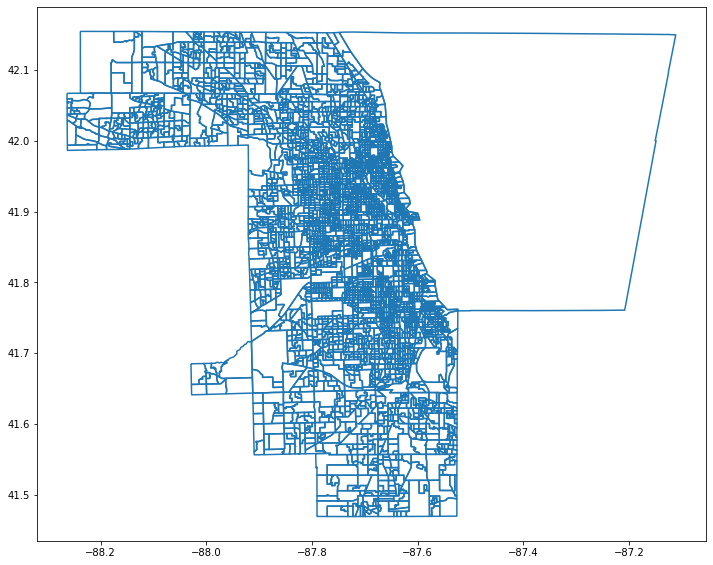

In [12]:
acs19_data.boundary.plot()

In [13]:
acs19_data.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,B01001_040,B01001_042,B01001_043,B01001_044,B01001_045,B01001_046,B01001_047,B01001_048,B01001_049,geometry
0,17,031,250500,2,170312505002,Block Group 2,G5030,S,327360,0,...,23,0,13,36,21,0,19,0,32,"POLYGON ((-87.79490 41.91266, -87.79466 41.912..."
1,17,031,250500,3,170312505003,Block Group 3,G5030,S,245840,0,...,39,27,0,0,33,14,32,16,0,"POLYGON ((-87.80223 41.91257, -87.80186 41.912..."
2,17,031,250500,4,170312505004,Block Group 4,G5030,S,246479,0,...,38,23,24,0,21,59,0,0,18,"POLYGON ((-87.80234 41.91623, -87.80197 41.916..."
3,17,031,640600,2,170316406002,Block Group 2,G5030,S,247285,0,...,40,5,15,8,0,19,10,13,9,"POLYGON ((-87.77394 41.77782, -87.77369 41.777..."
4,17,031,803603,2,170318036032,Block Group 2,G5030,S,3609675,0,...,32,0,0,19,0,50,0,0,21,"POLYGON ((-88.10205 42.12160, -88.10205 42.122..."


In [14]:
acs19_data.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'state',
       'county', 'tract', 'block grou', 'B01001_001', 'B01001_002',
       'B01001_003', 'B01001_004', 'B01001_005', 'B01001_006', 'B01001_007',
       'B01001_008', 'B01001_009', 'B01001_010', 'B01001_011', 'B01001_012',
       'B01001_013', 'B01001_014', 'B01001_015', 'B01001_016', 'B01001_017',
       'B01001_018', 'B01001_019', 'B01001_020', 'B01001_021', 'B01001_022',
       'B01001_023', 'B01001_024', 'B01001_025', 'B01001_026', 'B01001_027',
       'B01001_028', 'B01001_029', 'B01001_030', 'B01001_031', 'B01001_032',
       'B01001_033', 'B01001_034', 'B01001_035', 'B01001_036', 'B01001_037',
       'B01001_038', 'B01001_039', 'B01001_040', 'B01001_042', 'B01001_043',
       'B01001_044', 'B01001_045', 'B01001_046', 'B01001_047', 'B01001_048',
       'B01001_049', 'geometry'],
      dtype='object')

In [20]:
%%script false --no-raise-error
# fetch and extract beats shapefiles

urllib.request.urlretrieve('https://data.cityofchicago.org/api/geospatial/aerh-rz74?method=export&format=Shapefile','geo/beats.zip')

with zipfile.ZipFile('geo/beats.zip', 'r') as zip_ref:
    zip_ref.extractall('geo/beats')

In [15]:
police_beats = gpd.read_file('geo/beats/beats.shp')

In [16]:
# for basic mapping
def simple_map(data,boundary=True,variable=None,title=None):
    
    if variable is not None:
        fig = data.plot(column=variable,legend=True)
        if title is None:
            title = variable
    elif boundary:
        fig = data.boundary.plot()
    else:
        fig = data.plot()
    if title is not None:
        plt.title(title)
    return fig

<AxesSubplot:title={'center':'Census Tracts (2010s)'}>

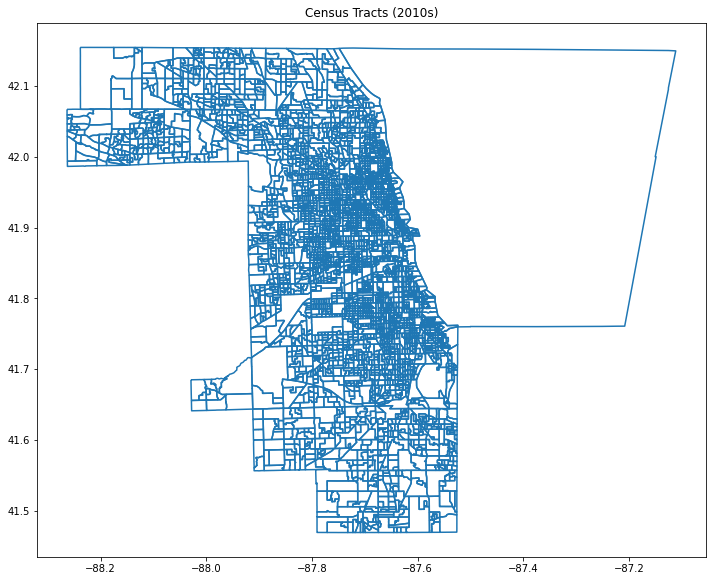

In [17]:
simple_map(acs19_data,boundary=True,title='Census Tracts (2010s)')

<AxesSubplot:title={'center':'Current Police Beats'}>

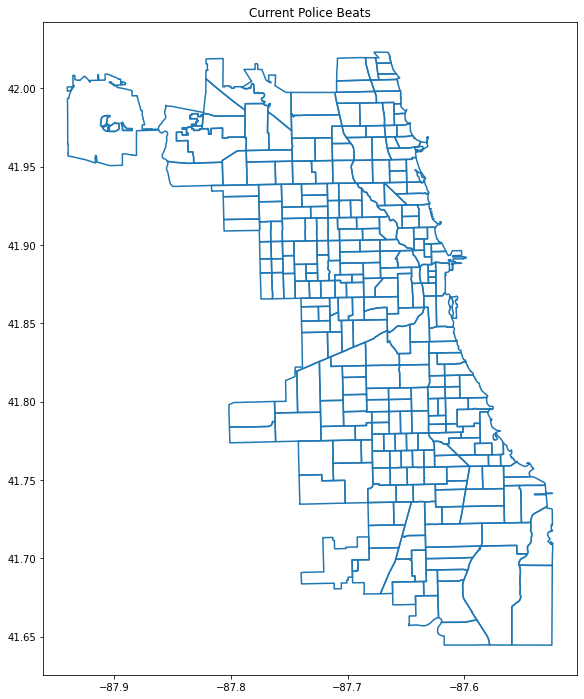

In [18]:
simple_map(police_beats,boundary=True,title='Current Police Beats')

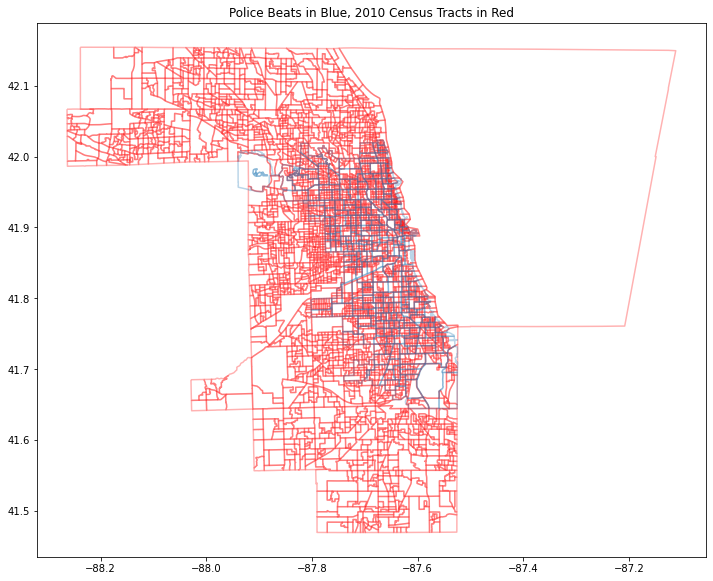

In [19]:
fig, ax = plt.subplots()
acs19_data.boundary.plot(color="red",alpha=0.3,ax=ax)
police_beats.boundary.plot(alpha=0.3,ax=ax)
plt.title('Police Beats in Blue, 2010 Census Tracts in Red')
plt.show()

In [20]:
# reproject geometries to equal-area projection to ensure we get accurate areas
# (should be pretty negligible difference at our scale, but for completeness' sake...)
police_beats = police_beats.to_crs("EPSG:3035")
acs19_data = acs19_data.to_crs("EPSG:3035")

In [21]:
# remove triplicate police beat
police_beats = police_beats[police_beats.beat_num != '3100']

<AxesSubplot:title={'center':'Unique Tract-Beat Combinations'}>

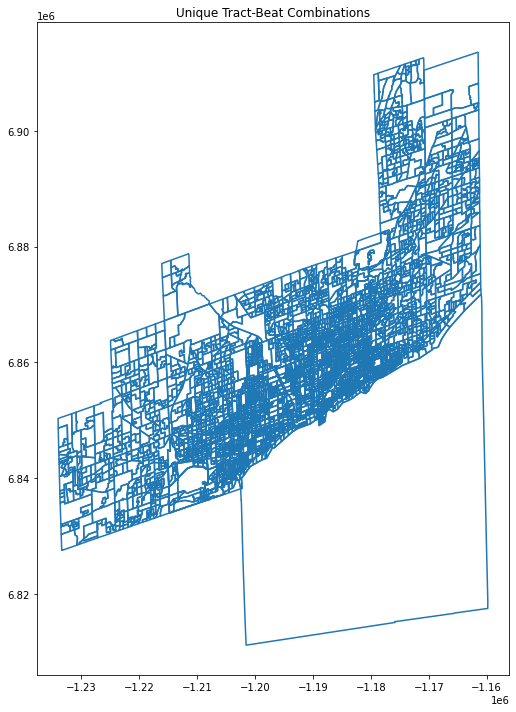

In [22]:
# We will use geopandas' spatial join function
# See https://geopandas.org/en/stable/docs/user_guide/set_operations.html
# We will first take the union of tracts and beats. Every resulting geometry is a unique combination of tract/beats that overlap
# (or the area of each tract/beat that doesn't overlap, if nonzero)

overlap = gpd.overlay(police_beats,acs19_data,how='union')
overlap['area'] = overlap.apply(lambda row: row.geometry.area,axis=1)  # force-recalculate areas
simple_map(overlap,boundary=True,title="Unique Tract-Beat Combinations")

In [23]:
overlap

,beat,beat_num,district,sector,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,...,B01001_042,B01001_043,B01001_044,B01001_045,B01001_046,B01001_047,B01001_048,B01001_049,geometry,area
0,1,1713,17,1,17,031,040300,3,170310403003,Block Group 3,...,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,"POLYGON ((-1179817.415 6861613.908, -1179818.2...",4.350127e+03
1,1,1911,19,1,17,031,040300,3,170310403003,Block Group 3,...,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,"MULTIPOLYGON (((-1180581.903 6860886.287, -118...",7.972269e+00
2,1,1712,17,1,17,031,040300,3,170310403003,Block Group 3,...,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,"POLYGON ((-1179817.354 6861613.931, -1179817.4...",1.249975e-01
3,1,2011,20,1,17,031,040300,3,170310403003,Block Group 3,...,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,"MULTIPOLYGON (((-1179801.368 6861120.058, -117...",4.094251e+00
4,3,2031,20,3,17,031,040300,3,170310403003,Block Group 3,...,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,"POLYGON ((-1180581.065 6860858.535, -1180581.2...",3.033104e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8534,None,None,None,None,17,031,820400,2,170318204002,Block Group 2,...,45.0,22.0,1.0,0.0,13.0,40.0,11.0,26.0,"POLYGON ((-1200964.619 6863696.238, -1200940.6...",4.709002e+05
8535,None,None,None,None,17,031,803015,3,170318030153,Block Group 3,...,0.0,47.0,26.0,21.0,20.0,35.0,52.0,13.0,"POLYGON ((-1164441.664 6887607.116, -1164365.3...",1.295849e+06
8536,None,None,None,None,17,031,821700,3,170318217003,Block Group 3,...,0.0,16.0,0.0,12.0,12.0,21.0,0.0,57.0,"POLYGON ((-1206343.306 6853420.021, -1206341.7...",5.156558e+05
8537,None,None,None,None,17,031,824003,3,170318240033,Block Group 3,...,12.0,67.0,13.0,0.0,92.0,13.0,104.0,112.0,"POLYGON ((-1213190.346 6873963.214, -1213180.3...",1.025286e+06


In [24]:
# remove areas that don't intersect beats
overlap = overlap.dropna(subset=["beat_num"])
overlap

,beat,beat_num,district,sector,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,...,B01001_042,B01001_043,B01001_044,B01001_045,B01001_046,B01001_047,B01001_048,B01001_049,geometry,area
0,1,1713,17,1,17,031,040300,3,170310403003,Block Group 3,...,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,"POLYGON ((-1179817.415 6861613.908, -1179818.2...",4.350127e+03
1,1,1911,19,1,17,031,040300,3,170310403003,Block Group 3,...,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,"MULTIPOLYGON (((-1180581.903 6860886.287, -118...",7.972269e+00
2,1,1712,17,1,17,031,040300,3,170310403003,Block Group 3,...,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,"POLYGON ((-1179817.354 6861613.931, -1179817.4...",1.249975e-01
3,1,2011,20,1,17,031,040300,3,170310403003,Block Group 3,...,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,"MULTIPOLYGON (((-1179801.368 6861120.058, -117...",4.094251e+00
4,3,2031,20,3,17,031,040300,3,170310403003,Block Group 3,...,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,"POLYGON ((-1180581.065 6860858.535, -1180581.2...",3.033104e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5358,1,0314,03,1,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-1200833.202 6844504.096, -120...",5.174303e-09
5359,2,0825,08,2,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-1199999.157 6852562.999, -119...",1.162354e-08
5360,1,0313,03,1,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-1200481.279 6845602.578, -120...",3.333594e-08
5361,2,0823,08,2,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-1201214.978 6853380.078, -120...",2.580720e-08


<AxesSubplot:>

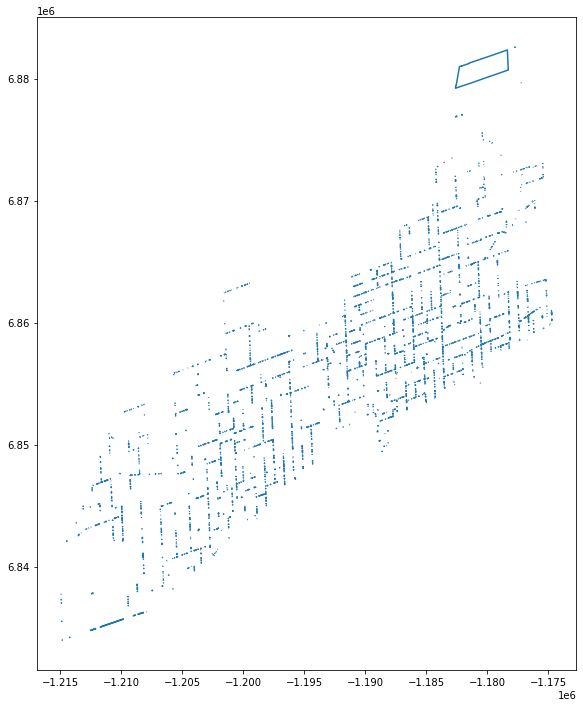

In [25]:
# where are the beats with no census overlap?
overlap[overlap["GEOID"].isna()].boundary.plot()

In [26]:
# this is a boundary-matching issue in a small subset of intersections - remove
overlap = overlap.dropna(subset=["GEOID"])
overlap

,beat,beat_num,district,sector,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,...,B01001_042,B01001_043,B01001_044,B01001_045,B01001_046,B01001_047,B01001_048,B01001_049,geometry,area
0,1,1713,17,1,17,031,040300,3,170310403003,Block Group 3,...,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,"POLYGON ((-1179817.415 6861613.908, -1179818.2...",4350.126613
1,1,1911,19,1,17,031,040300,3,170310403003,Block Group 3,...,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,"MULTIPOLYGON (((-1180581.903 6860886.287, -118...",7.972269
2,1,1712,17,1,17,031,040300,3,170310403003,Block Group 3,...,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,"POLYGON ((-1179817.354 6861613.931, -1179817.4...",0.124998
3,1,2011,20,1,17,031,040300,3,170310403003,Block Group 3,...,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,"MULTIPOLYGON (((-1179801.368 6861120.058, -117...",4.094251
4,3,2031,20,3,17,031,040300,3,170310403003,Block Group 3,...,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,"POLYGON ((-1180581.065 6860858.535, -1180581.2...",303310.394470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5094,2,0825,08,2,17,031,835000,2,170318350002,Block Group 2,...,0.0,0.0,15.0,0.0,16.0,7.0,0.0,20.0,"POLYGON ((-1200409.073 6853040.558, -1200408.2...",123703.315801
5095,2,0825,08,2,17,031,835000,4,170318350004,Block Group 4,...,0.0,40.0,9.0,7.0,54.0,28.0,41.0,49.0,"POLYGON ((-1200422.595 6853351.522, -1200421.7...",123021.486359
5096,2,0823,08,2,17,031,660400,2,170316604002,Block Group 2,...,11.0,19.0,0.0,7.0,22.0,6.0,8.0,39.0,"POLYGON ((-1200485.460 6854801.838, -1200483.8...",163086.241755
5097,2,0823,08,2,17,031,660400,3,170316604003,Block Group 3,...,0.0,21.0,0.0,9.0,25.0,7.0,19.0,0.0,"POLYGON ((-1200503.118 6855206.482, -1200501.3...",160083.593855


In [27]:
# now we will add two columns to overlap:
# the fraction of relevant beat in each intersected area
overlap["beat_frac"] = 0
# the fraction of relevant tract in each intersected area
overlap["bg_frac"] = 0

# select only needed columns
EXTENSIVE_VARIABLES = [
    'B01001_001', 'B01001_002',
    'B01001_003', 'B01001_004', 'B01001_005', 'B01001_006', 'B01001_007',
    'B01001_008', 'B01001_009', 'B01001_010', 'B01001_011', 'B01001_012',
    'B01001_013', 'B01001_014', 'B01001_015', 'B01001_016', 'B01001_017',
    'B01001_018', 'B01001_019', 'B01001_020', 'B01001_021', 'B01001_022',
    'B01001_023', 'B01001_024', 'B01001_025', 'B01001_026', 'B01001_027',
    'B01001_028', 'B01001_029', 'B01001_030', 'B01001_031', 'B01001_032',
    'B01001_033', 'B01001_034', 'B01001_035', 'B01001_036', 'B01001_037',
    'B01001_038', 'B01001_039', 'B01001_040', 'B01001_042', 'B01001_043',
    'B01001_044', 'B01001_045', 'B01001_046', 'B01001_047', 'B01001_048',
    'B01001_049'
]
overlap = overlap[
        ['beat_num', 'GEOID','geometry','beat_frac','bg_frac']+EXTENSIVE_VARIABLES
    ]
    
overlap.head()

/project/graziul/ra/drewkeller/geoconda/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,beat_num,GEOID,geometry,beat_frac,bg_frac,B01001_001,B01001_002,B01001_003,B01001_004,B01001_005,...,B01001_039,B01001_040,B01001_042,B01001_043,B01001_044,B01001_045,B01001_046,B01001_047,B01001_048,B01001_049
0,1713,170310403003,"POLYGON ((-1179817.415 6861613.908, -1179818.2...",0,0,849.0,348.0,30.0,17.0,0.0,...,9.0,29.0,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0
1,1911,170310403003,"MULTIPOLYGON (((-1180581.903 6860886.287, -118...",0,0,849.0,348.0,30.0,17.0,0.0,...,9.0,29.0,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0
2,1712,170310403003,"POLYGON ((-1179817.354 6861613.931, -1179817.4...",0,0,849.0,348.0,30.0,17.0,0.0,...,9.0,29.0,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0
3,2011,170310403003,"MULTIPOLYGON (((-1179801.368 6861120.058, -117...",0,0,849.0,348.0,30.0,17.0,0.0,...,9.0,29.0,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0
4,2031,170310403003,"POLYGON ((-1180581.065 6860858.535, -1180581.2...",0,0,849.0,348.0,30.0,17.0,0.0,...,9.0,29.0,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0


In [28]:
# force recalculate areas
police_beats['area'] = police_beats.apply(lambda row: row.geometry.area,axis=1)
acs19_data['area'] = acs19_data.apply(lambda row: row.geometry.area,axis=1)
overlap['area'] = overlap.apply(lambda row: row.geometry.area,axis=1)

# fill in:
for row_index in range(len(overlap)):
    area = overlap.iloc[row_index]['area']  # fetches area
    beat_num = overlap.iat[row_index,0]  # fetches beat_num
    beat_area = police_beats[police_beats.beat_num==beat_num].area
    overlap.iat[row_index,3] = area/beat_area  # sets beat_frac
    bg_id = overlap.iat[row_index,1]  # fetches bg
    bg_area = acs19_data[acs19_data.GEOID==bg_id].area
    overlap.iat[row_index,4] = area/bg_area  # sets tract_frac

overlap.head()

/project/graziul/ra/drewkeller/geoconda/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,beat_num,GEOID,geometry,beat_frac,bg_frac,B01001_001,B01001_002,B01001_003,B01001_004,B01001_005,...,B01001_040,B01001_042,B01001_043,B01001_044,B01001_045,B01001_046,B01001_047,B01001_048,B01001_049,area
0,1713,170310403003,"POLYGON ((-1179817.415 6861613.908, -1179818.2...",3.709921e-03,1.413881e-02,849.0,348.0,30.0,17.0,0.0,...,29.0,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,4350.126613
1,1911,170310403003,"MULTIPOLYGON (((-1180581.903 6860886.287, -118...",3.489188e-06,2.591152e-05,849.0,348.0,30.0,17.0,0.0,...,29.0,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,7.972269
2,1712,170310403003,"POLYGON ((-1179817.354 6861613.931, -1179817.4...",2.422651e-08,4.062678e-07,849.0,348.0,30.0,17.0,0.0,...,29.0,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,0.124998
3,2011,170310403003,"MULTIPOLYGON (((-1179801.368 6861120.058, -117...",1.740067e-06,1.330716e-05,849.0,348.0,30.0,17.0,0.0,...,29.0,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,4.094251
4,2031,170310403003,"POLYGON ((-1180581.065 6860858.535, -1180581.2...",2.360057e-01,9.858216e-01,849.0,348.0,30.0,17.0,0.0,...,29.0,13.0,19.0,29.0,46.0,6.0,0.0,0.0,24.0,303310.394470


In [29]:
# check - we want to see beat fractions sum to 1:
np.mean(overlap.groupby("beat_num").sum()["beat_frac"])

0.999064861495572

In [30]:
# check - we want to see bg fractions sum to close to 1 (may be a bit less bc of water and city-edge bgs):
np.mean(overlap.groupby("GEOID").sum()["bg_frac"])

0.9243431422955345

<AxesSubplot:>

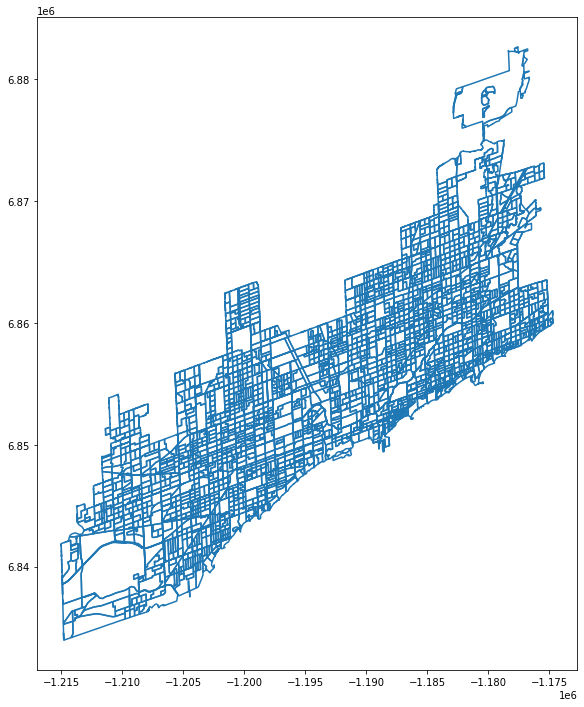

In [31]:
simple_map(overlap,boundary=True)

In [32]:
# save
overlap[["beat_num","GEOID","beat_frac","bg_frac"]].to_csv('data/blockgroup_beat_crosswalk.csv',index=False)
overlap.to_file('geo/blockgroup_beat_crosswalk/blockgroup_beat_crosswalk.shp')

In [33]:
# assuming homogeneous block groups, calculate population stats per bg fragment
for variable in EXTENSIVE_VARIABLES:
    overlap[variable] *= overlap.bg_frac

overlap.head()

/project/graziul/ra/drewkeller/geoconda/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,beat_num,GEOID,geometry,beat_frac,bg_frac,B01001_001,B01001_002,B01001_003,B01001_004,B01001_005,...,B01001_040,B01001_042,B01001_043,B01001_044,B01001_045,B01001_046,B01001_047,B01001_048,B01001_049,area
0,1713,170310403003,"POLYGON ((-1179817.415 6861613.908, -1179818.2...",3.709921e-03,1.413881e-02,12.003851,4.920307,0.424164,0.240360,0.0,...,0.410026,0.183805,0.268637,0.410026,0.650385,0.084833,0.0,0.0,0.339331,4350.126613
1,1911,170310403003,"MULTIPOLYGON (((-1180581.903 6860886.287, -118...",3.489188e-06,2.591152e-05,0.021999,0.009017,0.000777,0.000440,0.0,...,0.000751,0.000337,0.000492,0.000751,0.001192,0.000155,0.0,0.0,0.000622,7.972269
2,1712,170310403003,"POLYGON ((-1179817.354 6861613.931, -1179817.4...",2.422651e-08,4.062678e-07,0.000345,0.000141,0.000012,0.000007,0.0,...,0.000012,0.000005,0.000008,0.000012,0.000019,0.000002,0.0,0.0,0.000010,0.124998
3,2011,170310403003,"MULTIPOLYGON (((-1179801.368 6861120.058, -117...",1.740067e-06,1.330716e-05,0.011298,0.004631,0.000399,0.000226,0.0,...,0.000386,0.000173,0.000253,0.000386,0.000612,0.000080,0.0,0.0,0.000319,4.094251
4,2031,170310403003,"POLYGON ((-1180581.065 6860858.535, -1180581.2...",2.360057e-01,9.858216e-01,836.962507,343.065904,29.574647,16.758967,0.0,...,28.588825,12.815680,18.730610,28.588825,45.347792,5.914929,0.0,0.0,23.659718,303310.394470


In [34]:
overlap_bybeats = overlap.groupby("beat_num")
output_beats = overlap_bybeats.sum()
output_beats = output_beats.reset_index().drop(columns=["beat_frac"]).rename(columns={"bg_frac":"constituent_block_groups"})
output_beats

,beat_num,constituent_block_groups,B01001_001,B01001_002,B01001_003,B01001_004,B01001_005,B01001_006,B01001_007,B01001_008,...,B01001_040,B01001_042,B01001_043,B01001_044,B01001_045,B01001_046,B01001_047,B01001_048,B01001_049,area
0,0111,0.671467,2287.564183,1153.535832,13.770201,6.022862,9.244393,1.260599,19.327424,7.582849,...,27.791762,28.904565,6.506420,4.316840,0.008088,34.046468,4.438273,0.000000,0.000000,2.783753e+05
1,0112,0.272341,960.105236,501.506189,13.510553,5.506548,8.836431,2.745545,46.056882,15.111915,...,10.210743,8.632621,8.472503,4.281518,2.636709,13.483912,4.068398,0.000000,0.000000,2.241200e+05
2,0113,0.273625,952.288683,517.248931,6.045260,3.716100,6.275339,3.145673,55.185391,16.659914,...,14.742276,11.747497,7.812968,3.292042,3.919257,1.714675,0.734861,0.000000,0.000000,2.279838e+05
3,0114,4.156903,13566.781530,6493.002380,250.517907,55.365279,3.282458,11.367673,285.542328,64.629494,...,233.617421,219.689275,215.144073,189.629017,176.736805,282.038334,514.028447,88.280014,111.014479,1.742259e+06
4,0121,3.567936,6637.211809,3373.393449,137.986829,39.442251,0.111975,0.017072,66.050725,41.901666,...,109.590024,22.706461,18.561996,80.612513,59.477901,10.408469,9.129024,0.000000,0.000000,6.879686e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,2531,6.555564,6431.913949,2657.727745,52.127792,229.842503,235.255681,104.958424,108.843430,62.235775,...,270.402576,77.072796,218.621873,59.385055,152.961657,177.165655,0.114916,64.006318,22.025170,1.141864e+06
270,2532,8.603625,9689.913129,4440.531397,387.606656,275.165685,310.646475,153.412208,70.481135,54.076343,...,430.633748,111.001680,409.743724,105.919736,139.048076,184.912267,90.070914,48.897992,56.869517,1.168616e+06
271,2533,8.566874,11225.025448,5278.169844,389.908831,313.364698,485.441277,327.925966,131.905085,102.726479,...,342.626684,187.248497,196.219562,83.539424,134.288750,251.359263,127.437560,24.603794,47.170092,2.630952e+06
272,2534,8.203750,11984.451828,5928.843347,472.090188,503.425972,480.058173,202.874000,291.700072,145.564817,...,316.358523,96.070114,131.107885,81.812078,65.800881,132.174881,94.101267,32.994764,57.867791,1.311676e+06


In [35]:
# merge back to beats
augmented_beats = pd.merge(police_beats,output_beats,on="beat_num")
augmented_beats

,beat,beat_num,district,sector,geometry,area_x,constituent_block_groups,B01001_001,B01001_002,B01001_003,...,B01001_040,B01001_042,B01001_043,B01001_044,B01001_045,B01001_046,B01001_047,B01001_048,B01001_049,area_y
0,1,1713,17,1,"POLYGON ((-1179817.415 6861613.908, -1179818.2...",1.172566e+06,7.575009,13656.927370,6689.469639,494.627475,...,203.544576,172.568858,164.402689,77.574290,85.612457,105.587342,129.853009,78.289619,97.494267,1.172566e+06
1,5,1651,16,5,"POLYGON ((-1180095.971 6878906.579, -1180209.9...",2.942183e+05,0.014724,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.942183e+05
2,1,1914,19,1,"POLYGON ((-1180343.789 6856285.493, -1180323.3...",1.182412e+06,9.004925,12029.122983,6173.116410,271.817169,...,268.903431,137.137604,143.585698,67.072523,178.448068,217.669417,123.036542,164.192956,112.212334,1.182412e+06
3,1,1915,19,1,"POLYGON ((-1180727.781 6855492.641, -1180748.1...",1.766237e+06,10.290827,11424.611637,5385.868701,157.585091,...,173.342256,74.982985,276.744482,81.123668,142.439852,161.211663,207.040691,208.795551,262.516244,1.766237e+06
4,1,1913,19,1,"POLYGON ((-1180449.123 6857519.312, -1180464.8...",6.229832e+05,5.102211,7756.555518,4076.143025,215.582309,...,271.532329,27.878208,53.345438,61.801315,62.624531,122.605233,5.947304,0.004420,24.984010,6.229832e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,1,0314,03,1,"POLYGON ((-1199848.019 6844713.022, -1199847.4...",1.129187e+06,3.618206,6010.549757,2778.090477,167.276357,...,222.380484,62.037707,99.361298,10.234004,76.431699,82.311036,26.510826,22.771060,52.053093,1.129187e+06
270,2,0825,08,2,"POLYGON ((-1199995.600 6852471.755, -1200187.2...",1.294710e+06,7.323489,7407.835796,3797.257949,244.463630,...,239.953657,77.056841,127.179621,50.794951,44.007089,169.925950,82.052081,99.641328,111.012077,1.294710e+06
271,1,0313,03,1,"POLYGON ((-1199923.046 6846393.471, -1199921.0...",6.532798e+05,4.667313,4510.833760,1793.023649,142.016045,...,145.030581,59.369132,124.665236,177.689814,61.337320,83.330337,84.056013,57.685316,28.667690,6.532798e+05
272,2,0823,08,2,"POLYGON ((-1200236.830 6853630.392, -1200248.0...",2.470406e+06,15.035936,20038.368628,10095.475905,711.133566,...,350.044539,163.478445,311.284939,98.445244,266.805757,328.792400,136.201637,120.790895,106.587993,2.470406e+06


In [36]:
def simple_choropleth(data,variable,title=None):
    data.plot(column=variable,legend=True)
    if title is None:
        title = variable
    plt.title(title)
    plt.show()

In [37]:
augmented_beats = augmented_beats.to_crs("EPSG:4326")

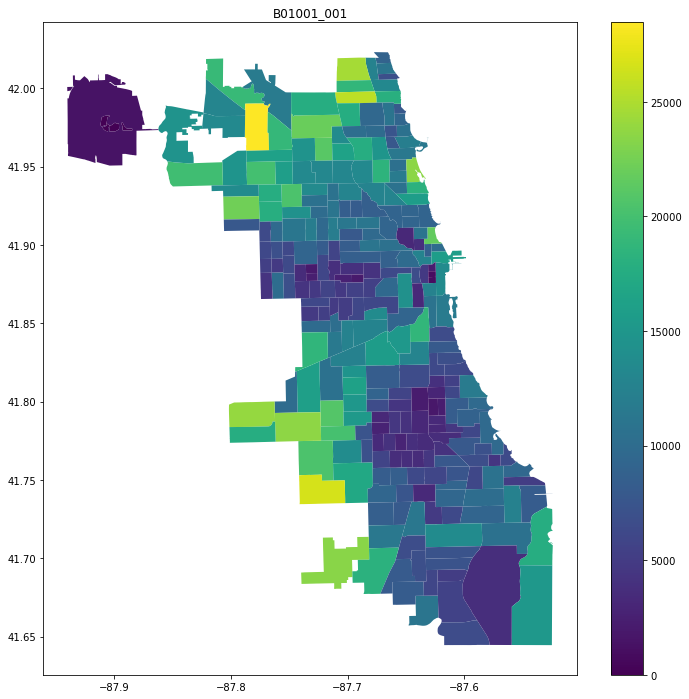

In [38]:
simple_choropleth(augmented_beats,'B01001_001')

This looks likely accurate (although should that one yellow beat's numbers really be that high?). One possible validation method is to apply this same procedure to aggregating population to community areas and then comparing against the city numbers.

In [39]:
# save
augmented_beats.drop(columns=["geometry","area_y"]).rename({"area_x":"area"}).to_csv('data/augmented_beats.csv',index=False)
augmented_beats.to_file('geo/augmented_beats/augmented_beats.shp')

/project/graziul/ra/drewkeller/geoconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# check
pd.read_csv('data/augmented_beats.csv')

,beat,beat_num,district,sector,area_x,constituent_block_groups,B01001_001,B01001_002,B01001_003,B01001_004,...,B01001_039,B01001_040,B01001_042,B01001_043,B01001_044,B01001_045,B01001_046,B01001_047,B01001_048,B01001_049
0,1,1713,17,1,1.172566e+06,7.575009,13656.927370,6689.469639,494.627475,433.646721,...,282.653086,203.544576,172.568858,164.402689,77.574290,85.612457,105.587342,129.853009,78.289619,97.494267
1,5,1651,16,5,2.942183e+05,0.014724,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,1914,19,1,1.182412e+06,9.004925,12029.122983,6173.116410,271.817169,349.805191,...,370.412603,268.903431,137.137604,143.585698,67.072523,178.448068,217.669417,123.036542,164.192956,112.212334
3,1,1915,19,1,1.766237e+06,10.290827,11424.611637,5385.868701,157.585091,68.020569,...,201.986490,173.342256,74.982985,276.744482,81.123668,142.439852,161.211663,207.040691,208.795551,262.516244
4,1,1913,19,1,6.229832e+05,5.102211,7756.555518,4076.143025,215.582309,54.168407,...,290.446751,271.532329,27.878208,53.345438,61.801315,62.624531,122.605233,5.947304,0.004420,24.984010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,1,314,3,1,1.129187e+06,3.618206,6010.549757,2778.090477,167.276357,239.446386,...,129.042953,222.380484,62.037707,99.361298,10.234004,76.431699,82.311036,26.510826,22.771060,52.053093
270,2,825,8,2,1.294710e+06,7.323489,7407.835796,3797.257949,244.463630,266.481389,...,239.628184,239.953657,77.056841,127.179621,50.794951,44.007089,169.925950,82.052081,99.641328,111.012077
271,1,313,3,1,6.532798e+05,4.667313,4510.833760,1793.023649,142.016045,143.000280,...,134.669473,145.030581,59.369132,124.665236,177.689814,61.337320,83.330337,84.056013,57.685316,28.667690
272,2,823,8,2,2.470406e+06,15.035936,20038.368628,10095.475905,711.133566,738.366585,...,676.256430,350.044539,163.478445,311.284939,98.445244,266.805757,328.792400,136.201637,120.790895,106.587993


Though none of the variables are intensive or margins of error, we will demonstrate below the method of interpolating those variable types.

In [ ]:
# for popweighted variables: 
# (1) calculate population of each fragment as an extensive variable
# (2) multiply FAKE_mean_income by population of each fragment ("total_FAKE_mean_income")
# (3) aggregate as above
# (4) divide total_FAKE_mean_income of each beat by population of each beat

# for margins of error:
# (1) square to get variance
# (2) aggregate as above
# (3) take square root to return to margin of error
# (Var(A+B)=Var(A)+Var(B)+2*Cov(A,B) and assume Cov(A,B) are uncorrelated for sampling error)

*Convert to form needed for interpolation script*

In [44]:
intersected_block_groups = overlap.dissolve(by='GEOID',aggfunc='sum')[["geometry","area"]]

In [45]:
# save
intersected_block_groups.to_file('geo/city_blockgroups/city_blockgroups.shp')

In [50]:
# save
intersected_block_groups[["area"]].reset_index().to_csv('./data/block_group_areas.csv')

In [51]:
crosswalk = pd.read_csv('./data/blockgroup_beat_crosswalk.csv')

In [52]:
crosswalk  # crosswalk: df where index is beats, columns are block groups, values are fraction of block group area in beat area

,beat_num,GEOID,beat_frac,bg_frac
0,1713,170310403003,3.709921e-03,1.413881e-02
1,1911,170310403003,3.489188e-06,2.591152e-05
2,1712,170310403003,2.422651e-08,4.062678e-07
3,2011,170310403003,1.740067e-06,1.330716e-05
4,2031,170310403003,2.360057e-01,9.858216e-01
...,...,...,...,...
5094,825,170318350002,9.554520e-02,1.000000e+00
5095,825,170318350004,9.501857e-02,1.000000e+00
5096,823,170316604002,6.601596e-02,1.000000e+00
5097,823,170316604003,6.480051e-02,1.000000e+00


In [56]:
new_crosswalk = crosswalk[["beat_num","GEOID","bg_frac"]].pivot(index='beat_num',columns='GEOID',values='bg_frac')

In [59]:
new_crosswalk

GEOID,170310101001,170310101002,170310101003,170310102011,170310102012,170310102013,170310102021,170310102022,170310103001,170310103002,...,170318438001,170318438002,170318439001,170318439002,170318439003,170318439004,170318439005,170319800001,170319801001,170319900000
beat_num,,,,,,,,,,,,,,,,,,,,,
111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000001
121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
new_crosswalk.loc[2011,170310403003]

1.3307162899278234e-05

In [65]:
new_crosswalk.fillna(value=0).to_csv('./data/blockgroup_beat_crosswalk.csv')

In [5]:
pd.read_csv('./data/block_group_areas.csv')[["GEOID","area"]].to_csv('./data/block_group_areas.csv',index=False)  # remove index


*Test `spatial_interpolation.py`*

In [3]:
import spatial_interpolation as si

In [4]:
acs19_data

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,B01001_040,B01001_042,B01001_043,B01001_044,B01001_045,B01001_046,B01001_047,B01001_048,B01001_049,geometry
0,17,031,250500,2,170312505002,Block Group 2,G5030,S,327360,0,...,23,0,13,36,21,0,19,0,32,"POLYGON ((-87.79490 41.91266, -87.79466 41.912..."
1,17,031,250500,3,170312505003,Block Group 3,G5030,S,245840,0,...,39,27,0,0,33,14,32,16,0,"POLYGON ((-87.80223 41.91257, -87.80186 41.912..."
2,17,031,250500,4,170312505004,Block Group 4,G5030,S,246479,0,...,38,23,24,0,21,59,0,0,18,"POLYGON ((-87.80234 41.91623, -87.80197 41.916..."
3,17,031,640600,2,170316406002,Block Group 2,G5030,S,247285,0,...,40,5,15,8,0,19,10,13,9,"POLYGON ((-87.77394 41.77782, -87.77369 41.777..."
4,17,031,803603,2,170318036032,Block Group 2,G5030,S,3609675,0,...,32,0,0,19,0,50,0,0,21,"POLYGON ((-88.10205 42.12160, -88.10205 42.122..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,17,031,820400,2,170318204002,Block Group 2,G5030,S,470920,0,...,97,45,22,1,0,13,40,11,26,"POLYGON ((-87.81297 41.77996, -87.81289 41.780..."
3989,17,031,803015,3,170318030153,Block Group 3,G5030,S,1295850,0,...,40,0,47,26,21,20,35,52,13,"POLYGON ((-87.94656 42.12331, -87.94654 42.124..."
3990,17,031,821700,3,170318217003,Block Group 3,G5030,S,515759,0,...,36,0,16,0,12,12,21,0,57,"POLYGON ((-87.71550 41.72786, -87.71502 41.727..."
3991,17,031,824003,3,170318240033,Block Group 3,G5030,S,1025287,0,...,43,12,67,13,0,92,13,104,112,"POLYGON ((-87.98019 41.66833, -87.98017 41.668..."


In [4]:
variables = {
    "B01001_042" : "extensive",
    "B01001_040" : "area-weighted",
    "B01001_043" : "B01001_042",
    "B01001_044" : "margin of error"
    }
si.blockgroups_to_beats(acs19_data,variables,source_geo="GEOID")

,area,B01001_042,B01001_040,B01001_043,B01001_044
beat_num,,,,,
111,2.782384e+05,28.904565,0.021074,0.005628,13.601817
112,1.882661e+05,8.632621,0.014628,0.005749,12.989398
113,1.748719e+05,11.747497,0.016414,0.004416,8.437801
114,1.260572e+06,219.689275,0.115721,0.812799,115.947481
121,6.879686e+05,22.706461,0.028070,0.000069,48.345476
...,...,...,...,...,...
2531,1.141568e+06,77.072796,0.071987,0.061422,43.260856
2532,1.168616e+06,111.001680,0.107123,0.172669,61.344338
2533,2.630952e+06,187.248497,0.196158,0.111082,36.962964


In [5]:
variables = {
    "this_wont_work" : "extensive",
    "B01001_040" : "area-weighted",
    "B01001_043" : "B01001_042",
    "B01001_044" : "margin of error"
    }
si.blockgroups_to_beats(acs19_data,variables,source_geo="GEOID")

ValueError: Specified variable 'this_wont_work' is not in dataframe.

In [6]:
variables = {
    "area" : "extensive",
    "B01001_040" : "area-weighted",
    "B01001_043" : "B01001_042",
    "B01001_044" : "margin of error"
    }
si.blockgroups_to_beats(acs19_data,variables,source_geo="GEOID")

ValueError: Please rename the 'area' variable, it might cause issues!

In [7]:
variables = {
    "this wont work either" : "extensive",
    "B01001_040" : "area-weighted",
    "B01001_043" : "B01001_042",
    "B01001_044" : "margin of error"
    }
example = acs19_data
example["this wont work either"] = np.nan
si.blockgroups_to_beats(example,variables,source_geo="GEOID")

ValueError: Remove NAs from passed data and try again.

In [8]:
variables = {
    "B01001_040" : "area-weighted",
    "B01001_043" : "B01001_042",
    "B01001_044" : "margin of error"
    }
si.blockgroups_to_beats(acs19_data,variables,source_geo="nope")

ValueError: Specified block group column 'nope' is not in dataframe.

In [9]:
variables = {
    "B01001_040" : "area-weighted",
    "B01001_043" : "B01001_042",
    "B01001_044" : "margin of error"
    }
si.blockgroups_to_beats(acs19_data,variables,source_geo="B01001_040")

Exception: Failed to merge data with block groups - check values of block group column 'B01001_040'.

In [11]:
test = pd.read_csv('data/augmented_beats.csv')

In [20]:
test = test.set_index("beat_num").sort_index()[["B01001_001", "B01001_002","B01001_048","B01001_049"]]
test

,B01001_001,B01001_002,B01001_048,B01001_049
beat_num,,,,
111,2287.564183,1153.535832,0.000000,0.000000
112,960.105236,501.506189,0.000000,0.000000
113,952.288683,517.248931,0.000000,0.000000
114,13566.781530,6493.002380,88.280014,111.014479
121,6637.211809,3373.393449,0.000000,0.000000
...,...,...,...,...
2531,6431.913949,2657.727745,64.006318,22.025170
2532,9689.913129,4440.531397,48.897992,56.869517
2533,11225.025448,5278.169844,24.603794,47.170092


In [13]:
variables = {
    "B01001_001" : "extensive",
    "B01001_002" : "extensive",
    "B01001_048" : "extensive",
    "B01001_049" : "extensive"
    }
si.blockgroups_to_beats(acs19_data,variables,source_geo="GEOID")

,area,B01001_001,B01001_002,B01001_048,B01001_049
beat_num,,,,,
111,2.782384e+05,2287.564183,1153.535832,0.000000,0.000000
112,1.882661e+05,960.105236,501.506189,0.000000,0.000000
113,1.748719e+05,952.288683,517.248931,0.000000,0.000000
114,1.260572e+06,13566.781530,6493.002380,88.280014,111.014479
121,6.879686e+05,6637.211809,3373.393449,0.000000,0.000000
...,...,...,...,...,...
2531,1.141568e+06,6431.913949,2657.727745,64.006318,22.025170
2532,1.168616e+06,9689.913129,4440.531397,48.897992,56.869517
2533,2.630952e+06,11225.025448,5278.169844,24.603794,47.170092


In [22]:
np.allclose(test,si.blockgroups_to_beats(acs19_data,variables,source_geo="GEOID").drop(columns=["area"]))

True